In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [2]:
df = pd.read_csv("Tweets.csv")
df[["airline_sentiment","text"]].head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


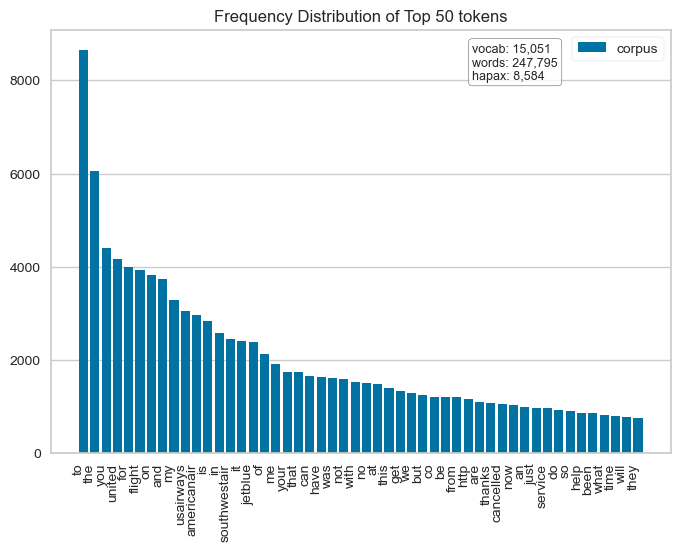

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [3]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [4]:
text = df["text"]
labels = df["airline_sentiment"]

print(text.shape, labels.shape)

(14640,) (14640,)


In [5]:
# remove digits, @-mentions, links, stopwords

text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"@[a-zA-Z0-9-]+", "", elem))
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in (nltk.corpus.stopwords.words() + ["rt"])]))

text.shape

(14640,)

In [6]:
import pickle
with open("text.pkl", "wb") as f:
  pickle.dump(text, f)
with open("labels.pkl", "wb") as f:
  pickle.dump(labels, f)

In [7]:
# with open("text.pkl", "rb") as f:
#   text = pickle.load(f)
# with open("labels.pkl", "rb") as f:
#   labels = pickle.load(f)

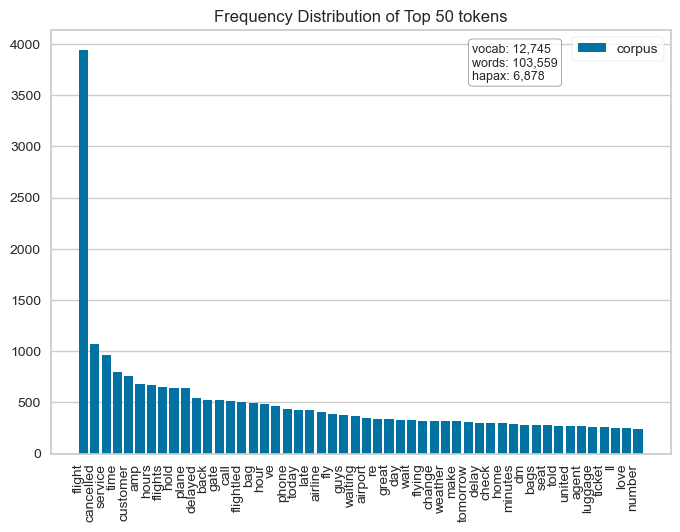

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [8]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(text)
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
lengths = []

X = text
for i in range(len(text)):
  X[i] = tokenizer.tokenize(X[i])
  X[i] = tokenizer.convert_tokens_to_ids(X[i])

for i in range(len(X)):
  lengths.append(len(X[i]))

In [11]:
lengths = np.array(lengths)
X = np.array(X)

print(np.sum((lengths < 64) & (labels == "positive")), np.mean((lengths < 64) & (labels == "positive")))
print(np.sum((lengths < 64) & (labels == "neutral")), np.mean((lengths < 64) & (labels == "neutral")))
print(np.sum((lengths < 64) & (labels == "negative")), np.mean((lengths < 64) & (labels == "negative")))

2363 0.16140710382513662
3099 0.21168032786885246
9178 0.6269125683060109


In [12]:
X_positive = X[(lengths < 64) & (labels == "positive")].tolist()
X_neutral = X[(lengths < 64) & (labels == "neutral")].tolist()
X_negative = X[(lengths < 64) & (labels == "negative")].tolist()
X = X_positive[:2000] + X_negative[:2000]

y_positive = labels[(lengths < 64) & (labels == "positive")].tolist()
y_neutral = labels[(lengths < 64) & (labels == "neutral")].tolist()
y_negative = labels[(lengths < 64) & (labels == "negative")].tolist()
y = y_positive[:2000] + y_negative[:2000]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=500, shuffle=True)

X_test = X_test[:50]
y_test = y_test[:50]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [14]:
import torch

model.config.max_position_embeddings = 64
max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [15]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2450, -0.1204, -0.0846,  ..., -1.0491,  0.3373, -0.0810],
         [ 0.1931,  0.3021,  0.4129,  ..., -0.3667, -0.1813,  0.0714],
         [ 0.4264,  0.2560,  0.2890,  ..., -0.5471, -0.2699,  0.1408],
         ...,
         [-0.3226, -0.2809, -0.0774,  ..., -0.9224,  0.4936, -0.2185],
         [-0.3276, -0.2857, -0.0894,  ..., -0.9114,  0.4906, -0.2167],
         [-0.3203, -0.2560, -0.1116,  ..., -0.9061,  0.4642, -0.2322]],

        [[-0.1961,  0.4264,  0.0336,  ..., -0.9017,  0.3346, -0.0777],
         [-0.6066,  0.1951,  0.1209,  ..., -0.6824,  0.4711,  0.2591],
         [-0.4802,  0.1073,  0.3012,  ..., -0.7115,  0.0834,  0.2893],
         ...,
         [ 0.1537, -0.0573,  0.2402,  ..., -0.8611,  0.5461, -0.1741],
         [ 0.1567, -0.0587,  0.2450,  ..., -0.8515,  0.5562, -0.1695],
         [ 0.1748, -0.0104,  0.2154,  ..., -0.8585,  0.5580, -0.2138]],

        [[-0.4119, -0.5482, -0.0111,  ..., -0.3747,  

In [16]:
bert_train_output = bert_train_output[1].detach().numpy().copy()
bert_train_output = bert_train_output.reshape(X_train.shape[0], 768)

In [17]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0308,  0.0386, -0.2124,  ..., -0.4442,  0.7377, -0.3769],
         [ 0.0021,  0.0998, -0.1865,  ..., -0.3281,  0.8163, -0.2365],
         [ 0.0504,  0.0803, -0.0489,  ..., -0.3055,  0.7059, -0.1777],
         ...,
         [ 0.0529, -0.0613, -0.0242,  ..., -0.5688,  0.7856, -0.3661],
         [ 0.0501, -0.0509, -0.0177,  ..., -0.5444,  0.8013, -0.3767],
         [ 0.0476, -0.0170, -0.0240,  ..., -0.5366,  0.7917, -0.3968]],

        [[ 0.0705,  0.1215,  0.1749,  ..., -0.5195,  0.7102, -0.1046],
         [-0.0349,  0.0421,  0.4810,  ..., -0.7055,  0.2295,  0.0282],
         [-0.1021,  0.0606,  0.4331,  ..., -0.7863,  0.0547, -0.0959],
         ...,
         [-0.0806,  0.0213,  0.2170,  ..., -0.4251,  0.7122, -0.2609],
         [-0.0904,  0.0422,  0.2189,  ..., -0.4067,  0.7334, -0.2579],
         [-0.0818,  0.0692,  0.1846,  ..., -0.3945,  0.7278, -0.2550]],

        [[-0.1111,  0.1405, -0.0385,  ..., -0.2005,  

In [18]:
bert_test_output = bert_test_output[1].detach().numpy().copy()
bert_test_output = bert_test_output.reshape(X_test.shape[0], 768)

In [19]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [20]:
clf = neural_network.MLPClassifier()
clf.fit(bert_train_output, le.transform(y_train))

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.


MLPClassifier(max_iter=100)

In [21]:
print("Train accuracy:", np.mean(clf.predict(bert_train_output) == le.transform(y_train)))
print("Test accuracy:", np.mean(clf.predict(bert_test_output) == le.transform(y_test)))

Train accuracy: 0.668
Test accuracy: 0.62


In [22]:
print(np.unique(y_test))

['negative' 'neutral' 'positive']


In [23]:
np.mean(y_test=="neutral")

0.26

In [24]:
shap.initjs()

In [25]:
to_explain = np.array(X_test_padded)[:20]
to_explain.shape

(20, 64)

In [26]:
def prediction_model(X):
  bert_output = model(torch.from_numpy(np.array(X)).to(torch.int64))
  sequence_output = bert_output[1].detach().numpy()
  return clf.predict(sequence_output.reshape(X.shape[0], 768))

In [27]:
permutation_values = []
permutation_explainer = shap.explainers.Permutation(prediction_model, to_explain)
for i in range(20):
  permutation_values.append(permutation_explainer(np.array([to_explain[i]])))

<class 'numpy.ndarray'> [[  999.   999.     0. ...     0.     0.     0.]
 [ 2191.  1013.  2689. ...     0.     0.     0.]
 [ 6728.  2389.  5202. ...     0.     0.     0.]
 ...
 [ 1005.  1055. 21888. ...     0.     0.     0.]
 [ 2651. 10418.  1012. ...     0.     0.     0.]
 [ 3462.  5388.  2581. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[ 999.  999.    0. ...    0.    0.    0.]
 [2191. 1013. 2689. ...    0.    0.    0.]
 [6728. 2389. 5202. ...    0.    0.    0.]
 ...
 [2322. 1061. 2869. ...    0.    0.    0.]
 [2322. 1061. 2869. ...    0.    0.    0.]
 [3462. 5388. 2581. ...    0.    0.    0.]]
<class 'numpy.ndarray'> [[  999.   999.     0. ...     0.     0.     0.]
 [ 2191.  1013.  2689. ...     0.     0.     0.]
 [ 6728.  2389.  5202. ...     0.     0.     0.]
 ...
 [ 1005.  1055. 21888. ...     0.     0.     0.]
 [ 3462.  5388.  2581. ...     0.     0.     0.]
 [ 2322.  1061.  2869. ...     0.     0.     0.]]
<class 'numpy.ndarray'> [[  999.   999.     0. ...     0.     0.

Permutation explainer: 2it [09:45, 585.39s/it]              


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
print(permutation_values)

.values =
array([[ 2.92857143e-01, -2.21428571e-01, -9.28571429e-02,
        -3.57142857e-02,  7.14285714e-02,  1.42857143e-01,
         2.14285714e-02,  5.00000000e-02, -2.00000000e-01,
         1.00000000e-01,  1.42857143e-01,  7.14285714e-02,
        -3.57142857e-02,  7.85714286e-02, -6.42857143e-02,
        -2.85714286e-02,  1.42857143e-02, -2.14285714e-02,
         1.50000000e-01, -1.42857143e-01,  2.14285714e-01,
         3.00000000e-01,  2.07142857e-01, -2.50000000e-01,
        -5.00000000e-02,  2.57142857e-01, -1.42857143e-01,
         7.14285714e-03, -7.14285714e-03, -5.71428571e-02,
        -7.14285714e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.0

<class 'numpy.ndarray'> [[ 1024  1036  1036  2187  4796  1019  2781  2220  1012  1005  1005  4301
   1024  1036  1036  1050  1005  1056  4175 16985 22911  2431  3178  1012
   1005  1005  1001  2272  2239  5051 27469     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: : ` ` left gate 5 minutes early . ' ' thoughts : ` ` n ' t count tar ##mac half hour . ' ' # come ##on ##pe ##ople ; Prediction: [2] ; True value: negative


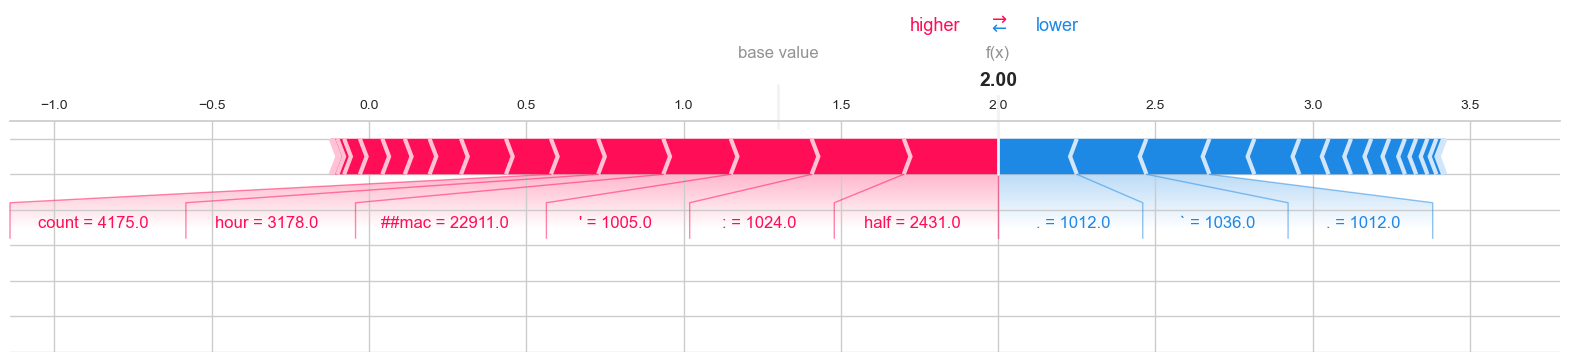

<class 'numpy.ndarray'> [[ 3438  2509  1004 23713  1025 13756  2629  1040  2546  2860  8827  2361
    999     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: 60 ##3 & amp ; 270 ##5 d ##f ##w ps ##p ! ; Prediction: [2] ; True value: positive


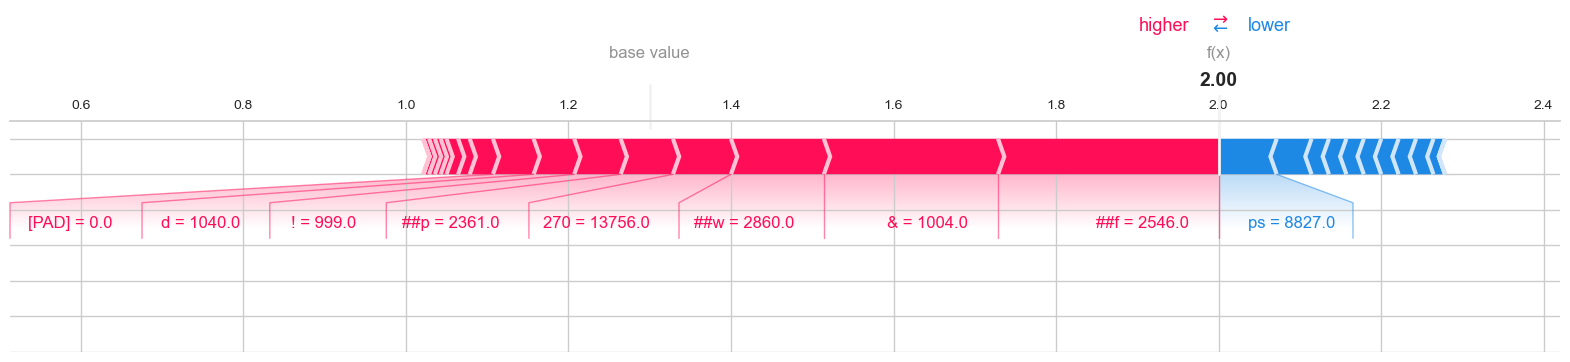

<class 'numpy.ndarray'> [[ 1040  5244  1010  1005  1049 12232 25416  8630  1012  3024  3967  2193
   2924  5371  4366     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: d ##ms , ' m owed ref ##und . provided contact number bank file claim ; Prediction: [0] ; True value: negative


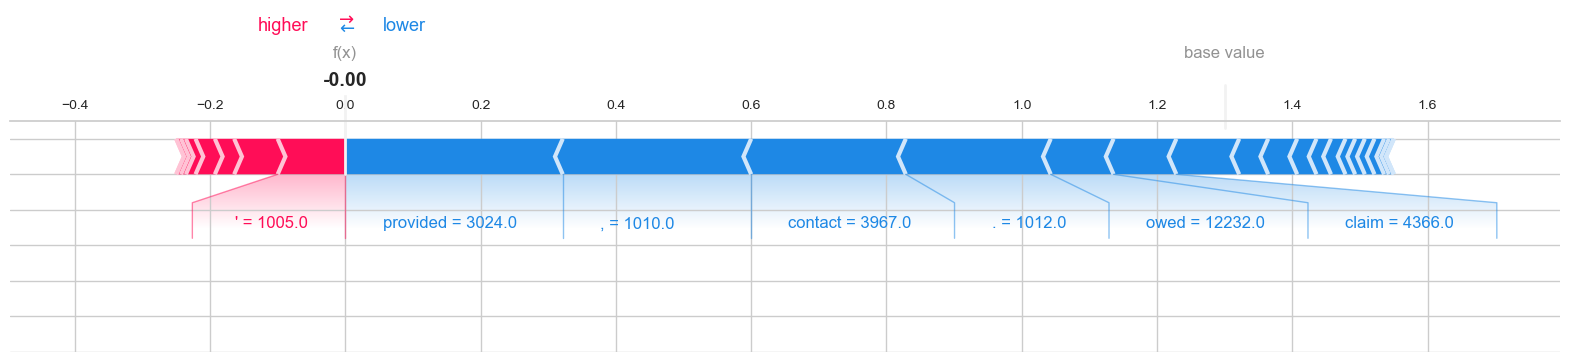

<class 'numpy.ndarray'> [[ 2439 29536 22368  5631 18440  6442  5553  2656  1012  1012     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: lost vo ##ucher miami aero ##port jan 26 . . ; Prediction: [2] ; True value: neutral


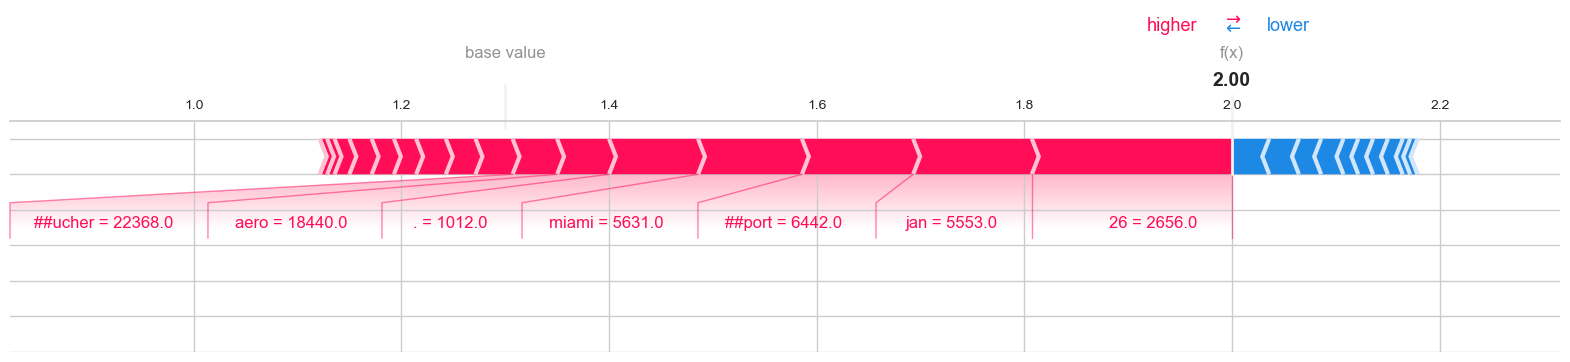

<class 'numpy.ndarray'> [[ 999 4633 1001 3731 1050 1005 1056 2307 1012 1005 1055 5458    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Sentence: ! weather # boston n ' t great . ' s tired ; Prediction: [2] ; True value: positive


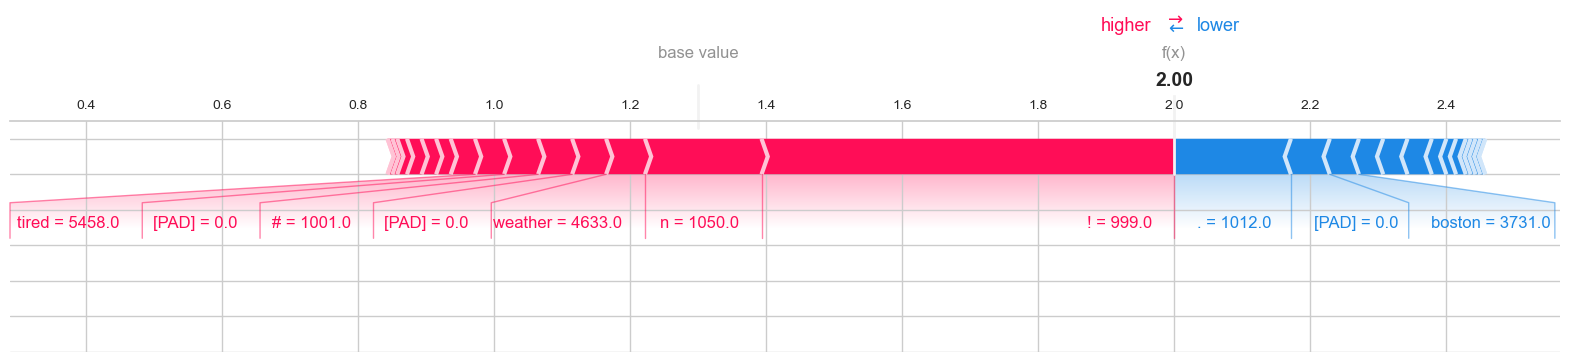

<class 'numpy.ndarray'> [[3564 4946 4407 2322 2781 3403 4946 1012 2307 2326  999    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Sentence: sitting plane philadelphia 20 minutes waiting plane . great service ! ; Prediction: [2] ; True value: positive


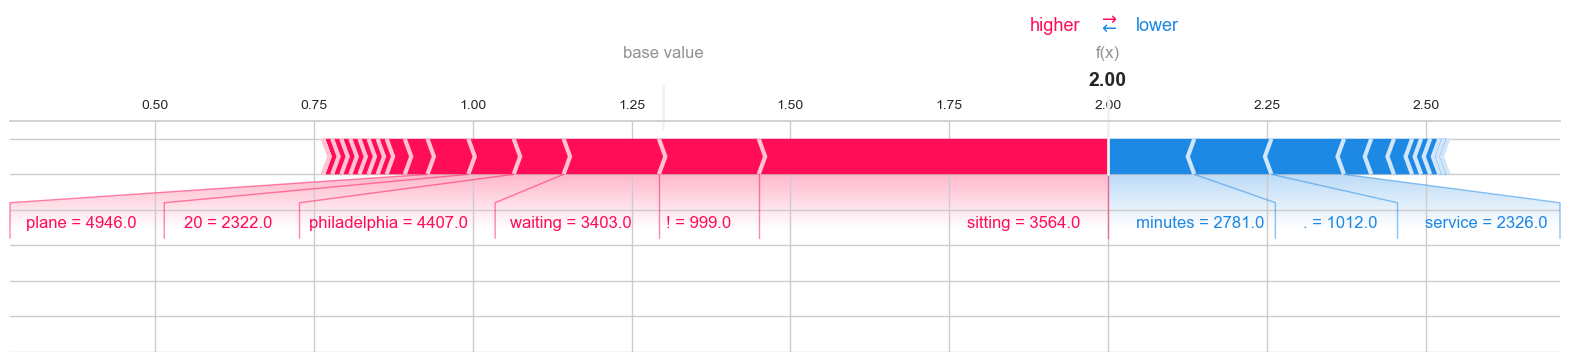

<class 'numpy.ndarray'> [[3246 2136 3105 3098  999    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Sentence: hope team job opening ! ; Prediction: [0] ; True value: positive


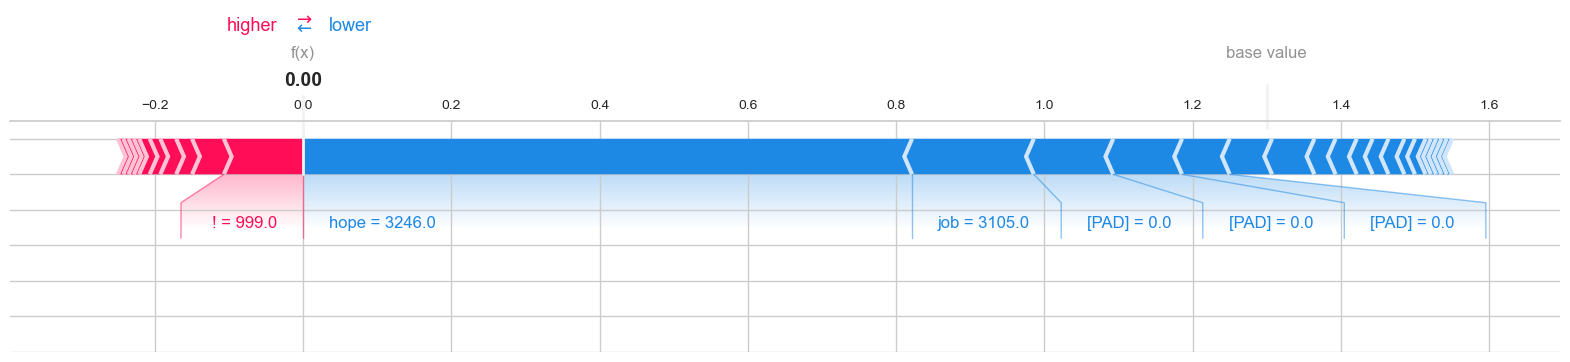

<class 'numpy.ndarray'> [[ 8013  2326 16392  3134  3283  1012  3048     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: customer service nyc weeks ago . moving ; Prediction: [0] ; True value: negative


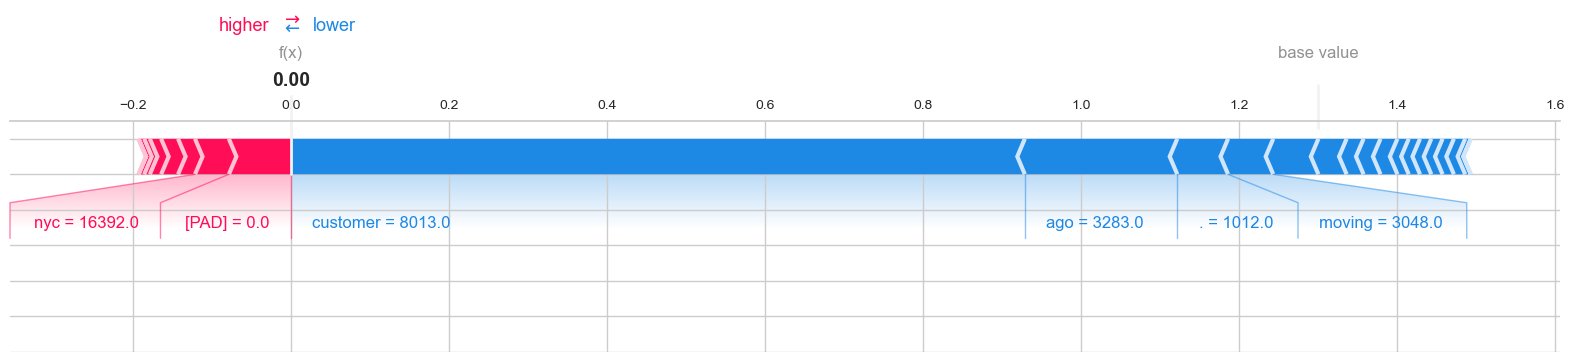

<class 'numpy.ndarray'> [[2307 4440 2627 2733 7136 2147 1025 4943 4943  999    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Sentence: great trip past week vegas work ; southwest southwest ! ; Prediction: [2] ; True value: positive


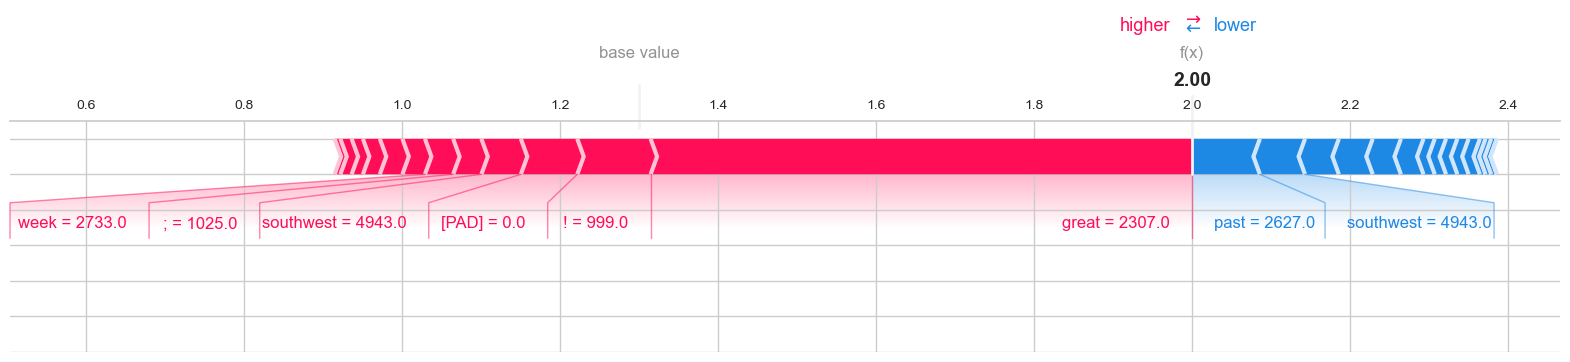

<class 'numpy.ndarray'> [[ 3967  2075  1012  3749  1002  6694  3604  8196  1001  2142 11215 12735
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Sentence: contact ##ing . offer $ 1000 travel certificate # united ##air ##lines ; Prediction: [1] ; True value: positive


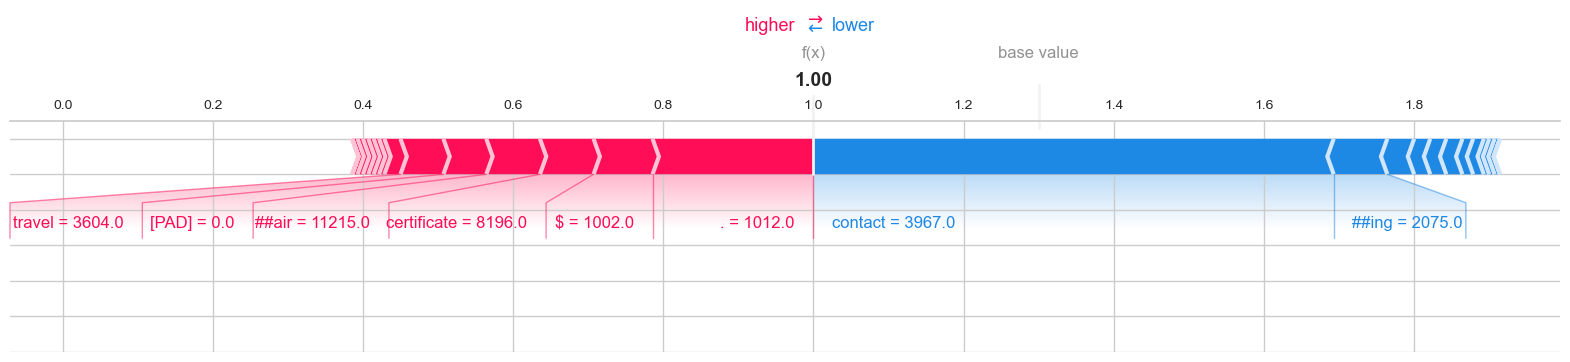

In [ ]:
for i in range(len(to_explain)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(to_explain[i])).replace(" [PAD]", "") ,"; Prediction:", prediction_model(np.array([to_explain[i]])), "; True value:", y_test[i])
  shap.plots.force(permutation_values.base_values[i], permutation_values.values[i], permutation_values.data[i], feature_names=tokenizer.convert_ids_to_tokens(permutation_values.data[i]), matplotlib=True)

In [4]:
print(permutation_values.base_values)

[1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3 1.3]


In [5]:
import copy
heatmaps = np.array(copy.copy(permutation_values.values))
heatmaps += permutation_values.base_values[0]/64
for i in range(len(heatmaps)):
  print(np.sum(heatmaps[i]))

2.0
2.0
0.0
2.0
1.9999999999999998
1.9999999999999998
0.0
-2.220446049250313e-16
2.0
0.9999999999999996


<class 'numpy.ndarray'> [[ 1024  1036  1036  2187  4796  1019  2781  2220  1012  1005  1005  4301
   1024  1036  1036  1050  1005  1056  4175 16985 22911  2431  3178  1012
   1005  1005  1001  2272  2239  5051 27469     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Prediction: positive


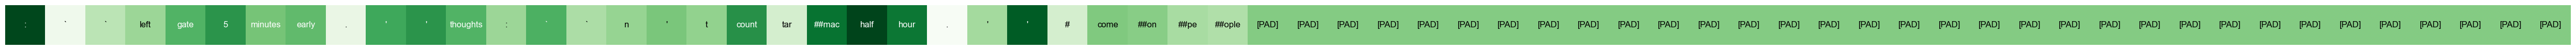

<class 'numpy.ndarray'> [[ 3438  2509  1004 23713  1025 13756  2629  1040  2546  2860  8827  2361
    999     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Prediction: positive


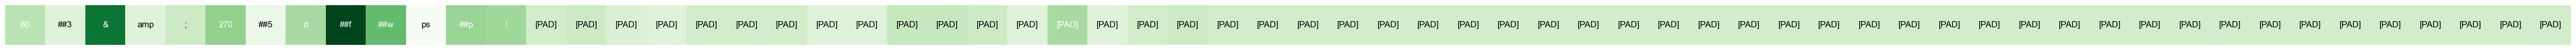

<class 'numpy.ndarray'> [[ 1040  5244  1010  1005  1049 12232 25416  8630  1012  3024  3967  2193
   2924  5371  4366     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Prediction: negative


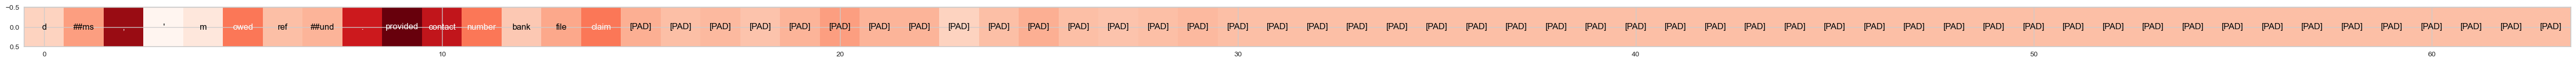

<class 'numpy.ndarray'> [[ 2439 29536 22368  5631 18440  6442  5553  2656  1012  1012     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Prediction: positive


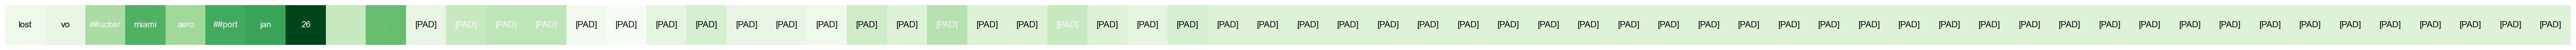

<class 'numpy.ndarray'> [[ 999 4633 1001 3731 1050 1005 1056 2307 1012 1005 1055 5458    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Prediction: positive


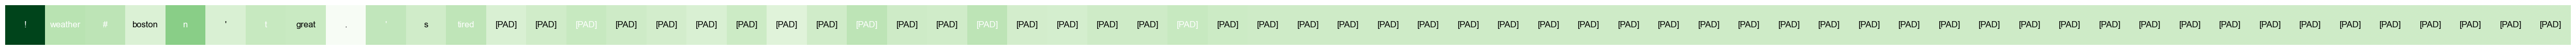

<class 'numpy.ndarray'> [[3564 4946 4407 2322 2781 3403 4946 1012 2307 2326  999    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Prediction: positive


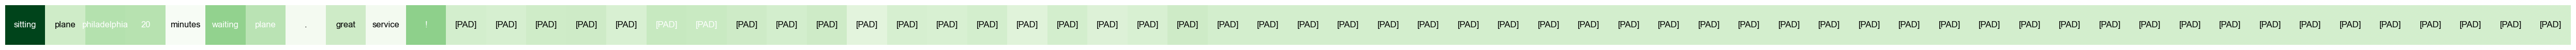

<class 'numpy.ndarray'> [[3246 2136 3105 3098  999    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Prediction: negative


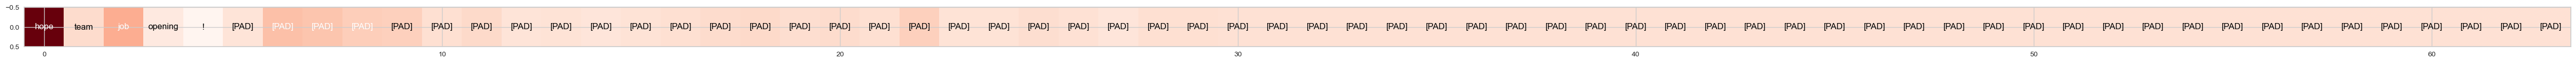

<class 'numpy.ndarray'> [[ 8013  2326 16392  3134  3283  1012  3048     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Prediction: negative


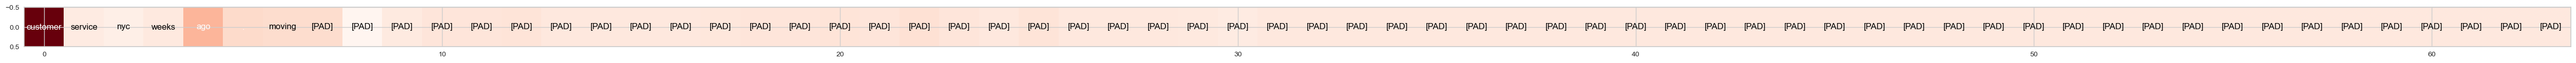

<class 'numpy.ndarray'> [[2307 4440 2627 2733 7136 2147 1025 4943 4943  999    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
Prediction: positive


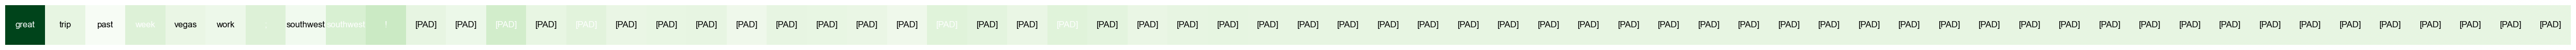

<class 'numpy.ndarray'> [[ 3967  2075  1012  3749  1002  6694  3604  8196  1001  2142 11215 12735
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]
Prediction: positive


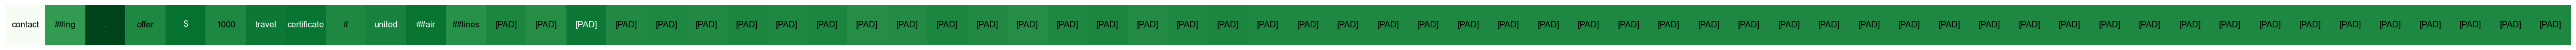

In [18]:
for x in range(len(to_explain)):
  fig, ax = plt.subplots(figsize=(len(to_explain[x]), 1))
  if prediction_model(np.array([to_explain[x]]))[0] == 0:
    print("Prediction: negative")
    ax.imshow([-heatmaps[x]], cmap="Reds", aspect="auto")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] < -0.04 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))
  else:
    print("Prediction: positive")
    ax.imshow([heatmaps[x]], cmap="Greens", aspect="auto")
    ax.axis("off")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] > 0.04 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))


  plt.show()

In [1]:
import dill
filename = 'globalsave.pkl'
dill.dump_session(filename)

# and to load the session again:
#dill.load_session(filename)